In [160]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

#### baca folder

In [181]:
train_folder = 'Dataset2AUTS/Training'  
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [183]:
category_paths = {category: os.path.join(train_folder, category) for category in categories}

membuat path yang benar ke folder kategori untuk setiap label gambar

## No 2A

#### Mengumpulkan semua path gambar dalam kategori untuk training dan testing

In [42]:
all_image_paths = []
all_labels = []

for label, category in enumerate(categories):
    category_path = category_paths[category]
    image_files = os.listdir(category_path)
    for image_file in image_files:
        all_image_paths.append(os.path.join(category_path, image_file))
        all_labels.append(label)

-> untuk ngumpulin path dari tiap gambar di folder category
<br>-> on.listdir = buat dapetin tiap file gambar dalam folder category
<br>-> all_labels = buat nyimpen label numerik untuk tiap category yang sesuai

#### membagi dataset menjadi train, validation, dan test

In [48]:
train_paths, temp_paths, train_labels, temp_labels = train_test_split(all_image_paths, all_labels, test_size=0.2, random_state=42)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.25, random_state=42)

train_test_split digunakan 2 kali unutk membagi dataset jadi 3 bagian yaitu masing-masing : 80% training, 15% validation, 5% testing

#### fungsi untuk memuat dan memproses gambar

In [185]:
def load_and_process_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0 
    return img_array

"fungsi" nya memuat gambar dan mengubah jadi array dengan image.img_to_array
<br> selanjutnya gambar dinormalisasi dengan membagi nilai pixel dengan 255, sehingga semua nilai pixel ada dalam rentang 0/1 (membantu proses pelatihan model)

#### menyiapkan data untuk training, validation, dan testing

In [57]:
train_images = np.array([load_and_process_image(path) for path in train_paths])
val_images = np.array([load_and_process_image(path) for path in val_paths])
test_images = np.array([load_and_process_image(path) for path in test_paths])

memproses gambar dari paths yang sudah dibagi
<br> menggunakan list comprehension untuk memuat dan memproses tiap gambar dan konversi menjadi array numpy

#### mengubah label menjadi array numpy

In [61]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

konversi label jadi numpy biar bisa diproses lebih lanjut dalam model

#### memeriksa dimensi data setelah pemrosesan

In [65]:
print(f"Training images shape: {train_images.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Test images shape: {test_images.shape}")

Training images shape: (4569, 224, 224, 3)
Validation images shape: (857, 224, 224, 3)
Test images shape: (286, 224, 224, 3)


masing masing nilai berisikan isi data(4569/80%),pixel gambar (224x224, dimensi target untuk proses gambar), dan channel warna(RGB)

#### contoh gambar dari dataset

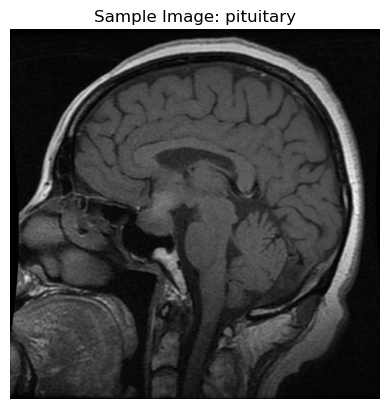

In [92]:
sample_image = cv2.imread(train_paths[112]) 
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)  
plt.imshow(sample_image)
plt.title(f"Sample Image: {categories[train_labels[0]]}")
plt.axis('off')
plt.show()

####  fungsi untuk menghitung histogram warna (RGB)

In [76]:
def calculate_histogram(image):
    hist_b = cv2.calcHist([image], [0], None, [256], [0, 256])  # Histogram untuk channel biru
    hist_g = cv2.calcHist([image], [1], None, [256], [0, 256])  # Histogram untuk channel hijau
    hist_r = cv2.calcHist([image], [2], None, [256], [0, 256])  # Histogram untuk channel merah
    return hist_b, hist_g, hist_r

histogram ini memberikan gambaran distribusi intensitas warna dalam gambar

#### menampilkan histogram warna untuk pituitary

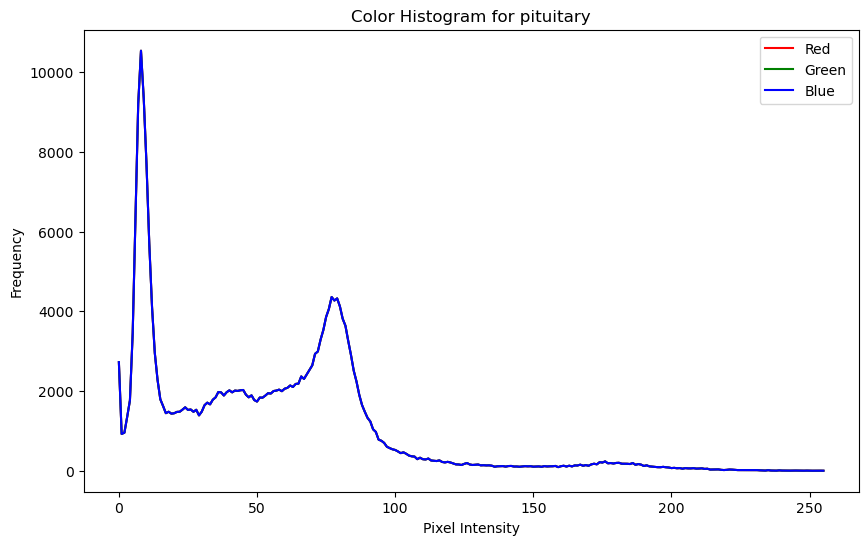

In [96]:
hist_b, hist_g, hist_r = calculate_histogram(sample_image)
plt.figure(figsize=(10, 6))
plt.plot(hist_r, color='r', label='Red')
plt.plot(hist_g, color='g', label='Green')
plt.plot(hist_b, color='b', label='Blue')
plt.title(f"Color Histogram for {categories[train_labels[112]]}")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

pada ct scan warna biru yang dominan dapat terjadi karena pemrosesan gambar yang digunakan untuk menonjolkan area tertentu

## No 2B

#### Menyiapkan data untuk training, validation, dan testing

In [100]:
train_images = np.array([load_and_process_image(path) for path in train_paths])
val_images = np.array([load_and_process_image(path) for path in val_paths])
test_images = np.array([load_and_process_image(path) for path in test_paths])

# Mengubah label menjadi array numpy
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

# Memeriksa dimensi data setelah pemrosesan
print(f"Training images shape: {train_images.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Test images shape: {test_images.shape}")

Training images shape: (4569, 224, 224, 3)
Validation images shape: (857, 224, 224, 3)
Test images shape: (286, 224, 224, 3)


data gambar dibagi 3 set, setiap set diproses untuk memastikan ukurannya sesuai (224x224) dan dinormalisasi (rentang 0-1) menggunakan fungsi `load_and_process_image`, setelah itu label untuk setiap set diubah menjadi array numpy

### baseline model CNN 

#### AlexNet

In [130]:
def build_alexnet(input_shape=(224, 224, 3), num_classes=4):
    model = models.Sequential()

    model.add(Input(shape=input_shape))

    # Layer 1: Convolutional + MaxPooling
    model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # Layer 2: Convolutional + MaxPooling
    model.add(layers.Conv2D(256, (5, 5), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # Layer 3,4,5
    model.add(layers.Conv2D(384, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(384, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # Flatten the output of the last convolutional layer
    model.add(layers.Flatten())

    # Fully Connected Layer 1
    model.add(layers.Dense(4096, activation='relu'))

    # Fully Connected Layer 2
    model.add(layers.Dense(4096, activation='relu'))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

model = build_alexnet(input_shape=(224, 224, 3), num_classes=4)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 54, 54, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 26, 26, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 26, 26, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 12, 12, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 12, 12, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 12, 12, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4096)                │      26,218,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │          16,388 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,763,396 (178.39 MB)

 Trainable params: 46,763,396 (178.39 MB)

 Non-trainable params: 0 (0.00 B)

membuat fungsi untuk model alexnet dengan argumen berisi pixel dan warna, lalu class = 4 karena ada 4 penyakit
<br> berikutnya bagian layer konvolusi dan pooling 
<br> Conv2d untuk mendeteksi fitur pada gambar seperti tepi, sudut, dan tekstur (96 filter digunakan untuk mendeteksi fitur,
 kernel size (11x11) menentukan ukuran filter yang digunakan,
strides (4,4) menentukan langkah filter saat bergerak melintasi gambar, dan
fungsi aktivasi ReLU yang memungkinkan jaringan belajar fitur non-linear.)
<br>
<br>
MaxPooling2d untuk mengurangi dimensi gambar (downsampling) untuk mengurangi komputasi dan memfokuskan model pada fitur penting.
<br>
(3, 3) adalah ukuran pool, dan
strides (2, 2) menentukan langkah saat pool diterapkan.
<br>
berikutnya layer konvolusi dan pooling tambahan 
<br> -> Conv2d sekarang dengan 256 filter, ukuran kernel 5x5 dan aktivasi relu
<br> -> lalu pooling lagi untuk mengurangidimensi gambar lebih lanjut
<br> selanjutnya layer konvolusi lanjutan yaitu:
<br> -> 384 filter pada dua lapisan konvolusi pertama untuk menangkap lebih banyak fitur dan 
256 filter pada lapisan terakhir untuk mengurangi dimensi fitur yang diekstraksi
<br> setelah itu ada lapisan flatten yang berfungsi mengubah hasil dari lapisan konvolusi dan pooling menjadi vektor satu dimensi sehingga dapat dimasukkan ke dalam lapisan fully connected/dense
<br> berikutnya fully connected layers dengan 4096 neuron, lapisan ini bertugas mengklasifikasikan fitur yang diekstrak menjadi output yang lebih konkret. fungsi aktivasi ReLU digunakan untuk kedua lapisan ini untuk menangani nonlinearitas dalam data
<br> lalu pada output layer fungsi aktivasi softmax digunakan untuk klasifikasi multiclass, mengubah output menjadi probabilitas untuk tiap kelas
<br> terakhir compile model dengan loss= sparse_categorical_crossentropy untuk klasifikasi multiclass dan digunakan ketika ketika label kelas adalah integer (bukan one-hot encoded)

#### train baseline model

In [137]:
history = model.fit(
    train_images,  
    train_labels,  
    epochs=10,  
    validation_data=(val_images, val_labels)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.3445 - loss: 1.7336 - val_accuracy: 0.6943 - val_loss: 0.7655
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.7327 - loss: 0.6887 - val_accuracy: 0.8413 - val_loss: 0.4581
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.8438 - loss: 0.4491 - val_accuracy: 0.8460 - val_loss: 0.4527
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.8624 - loss: 0.4305 - val_accuracy: 0.8611 - val_loss: 0.3779
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.8955 - loss: 0.3029 - val_accuracy: 0.8938 - val_loss: 0.2798
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.9146 - loss: 0.2659 - val_accuracy: 0.8891 - val_loss: 0.2705
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.8986 - loss: 0.2735 - val_accuracy: 0.9020 - val_loss: 0.2749
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.9210 - loss: 0.2221 - val_accu

#### grafik akurasi dan loss

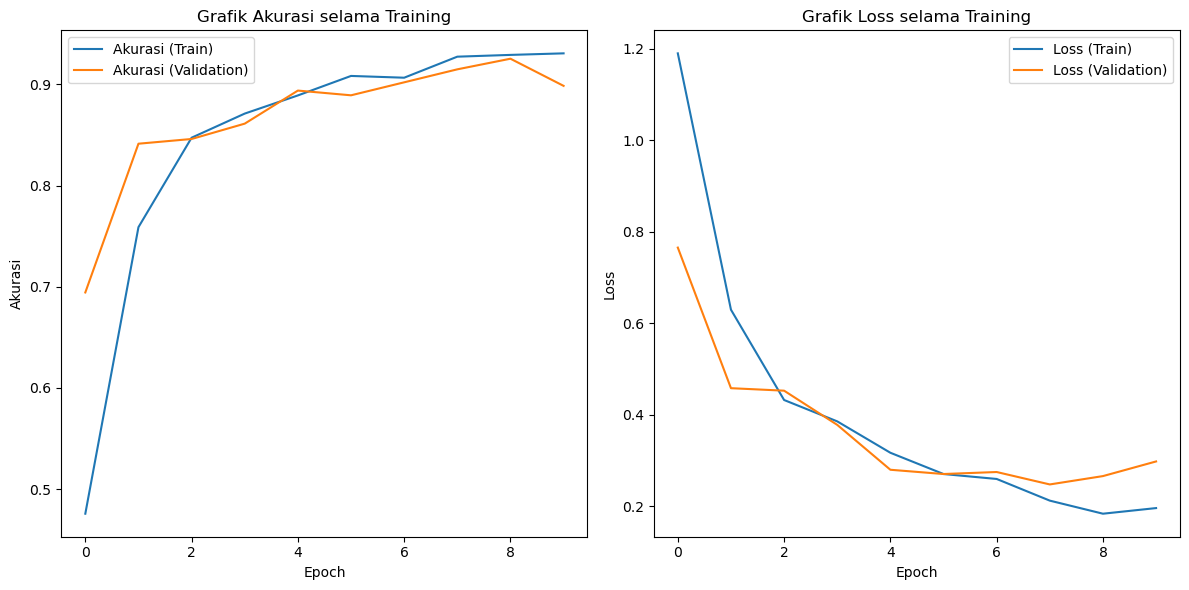

In [142]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi (Train)')
plt.plot(history.history['val_accuracy'], label='Akurasi (Validation)')
plt.title('Grafik Akurasi selama Training')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss (Train)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Grafik Loss selama Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

interpretasi grafik akurasi:
 - akurasi training menunjukkan peningkatan yang signifikan sejak epoch pertama, mencapai lebih dari 90% pada epoch ke-8. hal ini menunjukkan bahwa model belajar dengan baik pada data pelatihan dan mulai mengenali pola dalam dataset.

- akurasi validasi menunjukkan sedikit fluktuasi dan lebih rendah dibandingkan dengan akurasi pelatihan. ini adalah hal yang normal, karena data validasi terdiri dari data yang belum pernah dilihat oleh model sebelumnya.

grafik loss:
- loss training menurun secara konsisten selama epoch, yang menunjukkan bahwa model semakin baik dalam memprediksi data pelatihan. loss yang lebih rendah mengindikasikan bahwa model lebih akurat dalam prediksinya.

- loss validasi juga menurun selama beberapa epoch awal, namun setelah itu mengalami fluktuasi dan sedikit meningkat pada beberapa epoch terakhir.

note : overfitting terlihat dari perbedaan yang mulai lebar antara akurasi training dan validasi, serta loss yang meningkat pada validasi. hal ini menunjukkan bahwa meskipun model meningkatkan akurasi pada data pelatihan, model mulai kesulitan menggeneralisasi ke data validasi

#### Model EfficientNetB0 dengan Dropout dan Batch Normalization

In [162]:
def build_efficientnet(input_shape=(224, 224, 3), num_classes=4):
    base_model = EfficientNetB0(weights=None, include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model untuk fine-tuning

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),  # Batch Normalization untuk stabilisasi training
        layers.Dropout(0.5),  # Dropout untuk mengurangi overfitting
        layers.Dense(num_classes, activation='softmax')
    ])

    # fine-tuning
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

efficientnet_model = build_efficientnet(input_shape=(224, 224, 3), num_classes=4)

efficientnet_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,369,511 (20.48 MB)

 Trainable params: 1,317,892 (5.03 MB)

 Non-trainable params: 4,051,619 (15.46 MB)

Menggunakan model EfficientNetB0 yang telah di-pretrained, namun diatur agar tidak dapat diubah (tidak dapat dilatih) pada awalnya (base_model.trainable = False). hal ini memungkinkan kita untuk melakukan fine-tuning.

- batch Normalization: Ditambahkan setelah lapisan Dense untuk menstabilkan pelatihan, mempercepat konvergensi, dan mengurangi overfitting.

- dropout: Ditambahkan setelah lapisan Dense untuk mencegah overfitting dengan secara acak "menonaktifkan" sebagian neuron selama pelatihan.

- fine-tuning Hyperparameter: Menggunakan Adam optimizer dengan learning rate yang lebih kecil (0.0001), agar lebih stabil dalam melakukan fine-tuning.

#### train model

In [164]:
history_modified = efficientnet_model.fit(
    train_images, 
    train_labels, 
    epochs=20, 
    validation_data=(val_images, val_labels)
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.2772 - loss: 1.3851 - val_accuracy: 0.2602 - val_loss: 1.3863
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.2765 - loss: 1.3833 - val_accuracy: 0.2602 - val_loss: 1.3873
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.2919 - loss: 1.3815 - val_accuracy: 0.2602 - val_loss: 1.3875
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.2792 - loss: 1.3841 - val_accuracy: 0.2602 - val_loss: 1.3877
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.2788 - loss: 1.3828 - val_accuracy: 0.2602 - val_loss: 1.3879
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.2910 - loss: 1.3806 - val_accuracy: 0.2602 - val_loss: 1.3877
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.2926 - loss: 1.3806 - val_accuracy: 0.2602 - val_loss: 1.3875
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.2881 - loss: 1.3823 - val_accu

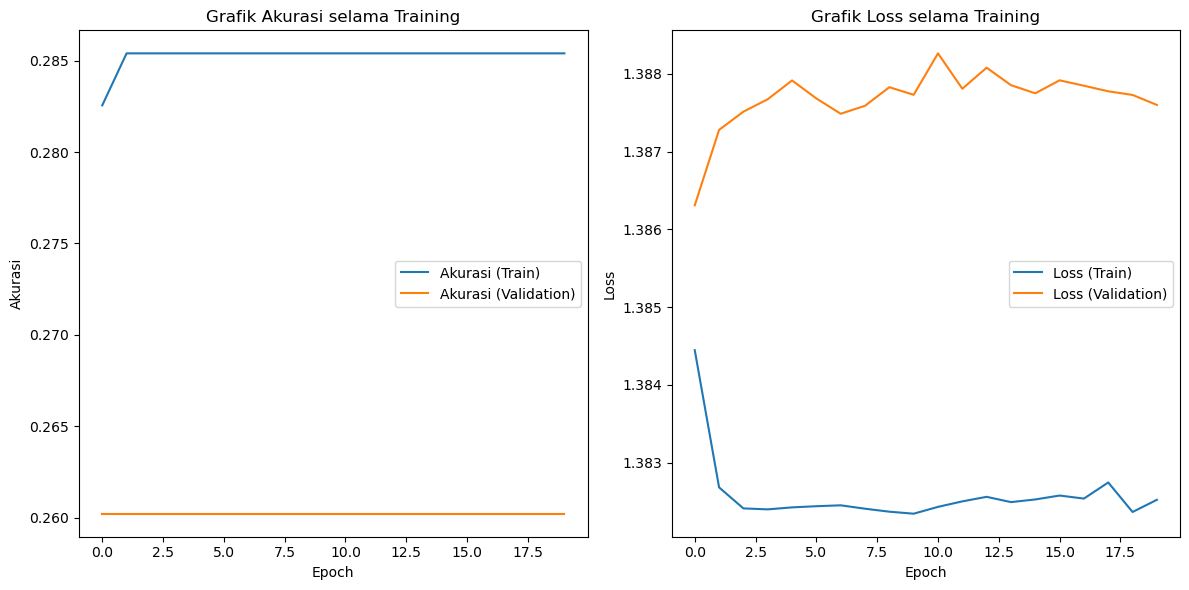

In [165]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_modified.history['accuracy'], label='Akurasi (Train)')
plt.plot(history_modified.history['val_accuracy'], label='Akurasi (Validation)')
plt.title('Grafik Akurasi selama Training')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_modified.history['loss'], label='Loss (Train)')
plt.plot(history_modified.history['val_loss'], label='Loss (Validation)')
plt.title('Grafik Loss selama Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [174]:
test_results_baseline = model.evaluate(test_images, test_labels)

print(f"Test Loss (Baseline AlexNet): {test_results_baseline[0]}")
print(f"Test Accuracy (Baseline AlexNet): {test_results_baseline[1]}")

from sklearn.metrics import classification_report
print("\nClassification Report (Baseline AlexNet):")
print(classification_report(test_labels, np.argmax(model.predict(test_images), axis=1), target_names=categories))

9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8508 - loss: 0.4613
Test Loss (Baseline AlexNet): 0.4220108091831207
Test Accuracy (Baseline AlexNet): 0.867132842540741

Classification Report (Baseline AlexNet):
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
              precision    recall  f1-score   support

      glioma       0.94      0.86      0.90        74
  meningioma       0.76      0.80      0.78        65
     notumor       0.81      1.00      0.89        68
   pituitary       0.97      0.81      0.88        79

    accuracy                           0.87       286
   macro avg       0.87      0.87      0.87       286
weighted avg       0.88      0.87      0.87       286



In [175]:
test_results_modified = efficientnet_model.evaluate(test_images, test_labels)

print(f"Test Loss (EfficientNet): {test_results_modified[0]}")
print(f"Test Accuracy (EfficientNet): {test_results_modified[1]}")

print("\nClassification Report (EfficientNet):")
print(classification_report(test_labels, np.argmax(efficientnet_model.predict(test_images), axis=1), target_names=categories, zero_division=1))

9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.2281 - loss: 1.3919
Test Loss (EfficientNet): 1.390674114227295
Test Accuracy (EfficientNet): 0.2377622425556183

Classification Report (EfficientNet):
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step
              precision    recall  f1-score   support

      glioma       1.00      0.00      0.00        74
  meningioma       1.00      0.00      0.00        65
     notumor       0.24      1.00      0.38        68
   pituitary       1.00      0.00      0.00        79

    accuracy                           0.24       286
   macro avg       0.81      0.25      0.10       286
weighted avg       0.82      0.24      0.09       286



Analisis Hasil Evaluasi:
1. Model Baseline (AlexNet)
Hasil Evaluasi:

Akurasi Test: 86.71%

Loss Test: 0.4613

Classification Report (AlexNet):

Precision:

Glioma: 0.94

Meningioma: 0.76

Notumor: 0.81

Pituitary: 0.97

Recall:

Glioma: 0.86

Meningioma: 0.80

Notumor: 1.00

Pituitary: 0.81

F1-Score:

Glioma: 0.90

Meningioma: 0.78

Notumor: 0.89

Pituitary: 0.88

Interpretasi:

Akurasi cukup tinggi (87% pada dataset uji), yang menunjukkan bahwa model dapat mengenali pola dengan baik.

Precision dan Recall untuk setiap kelas memiliki nilai yang cukup baik. Khususnya untuk kelas Pituitary, Precision dan Recall sangat tinggi (0.97 dan 0.81), meskipun untuk Meningioma, precision agak lebih rendah (0.76). Notumor memiliki Recall 1.00, yang berarti model dapat sepenuhnya mendeteksi semua kasus tanpa kehilangan apapun di kelas tersebut.

F1-Score untuk semua kelas cukup baik, menunjukkan keseimbangan yang baik antara precision dan recall.

2. Model Modifikasi (EfficientNet)
Hasil Evaluasi:

Akurasi Test: 23.77%

Loss Test: 1.3919

Classification Report (EfficientNet):

Precision:

Glioma: 1.00

Meningioma: 1.00

Notumor: 0.24

Pituitary: 1.00

Recall:

Glioma: 0.00

Meningioma: 0.00

Notumor: 1.00

Pituitary: 0.00

F1-Score:

Glioma: 0.00

Meningioma: 0.00

Notumor: 0.38

Pituitary: 0.00

Interpretasi:

Akurasi sangat rendah (23.77%) dibandingkan dengan model baseline (AlexNet). Ini menunjukkan bahwa EfficientNet yang dimodifikasi tidak dapat menggeneralisasi dengan baik pada data uji.

Precision untuk Glioma, Meningioma, dan Pituitary sangat tinggi (1.00), tetapi Recall untuk kelas-kelas tersebut adalah 0.00, yang menunjukkan bahwa model tidak berhasil mendeteksi kasus-kasus ini meskipun memberikan prediksi yang benar untuk sebagian kecil data.

Recall untuk Notumor adalah 1.00, yang menunjukkan model berhasil mendeteksi seluruh kasus Notumor, tetapi ini tidak cukup untuk meningkatkan performa model secara keseluruhan.

F1-Score untuk sebagian besar kelas sangat rendah, yang menunjukkan bahwa model EfficientNet gagal untuk menghasilkan keseimbangan yang baik antara precision dan recall.

kesimpulan:

Model Baseline (AlexNet):

Akurasi model pada data uji mencapai 86.71%, yang menunjukkan bahwa model ini dapat mengenali pola dengan baik.

Precision, Recall, dan F1-Score untuk sebagian besar kelas cukup baik. Kelas Pituitary memiliki precision dan recall yang sangat tinggi, meskipun kelas Meningioma memiliki precision yang lebih rendah (0.76).

Model ini berhasil mendeteksi sebagian besar kasus, dengan beberapa kelas seperti Notumor mencapai recall 1.00, tetapi ada sedikit penurunan pada recall untuk Pituitary.

Model Modifikasi (EfficientNet):

Akurasi model pada data uji sangat rendah, hanya 23.77%, yang menunjukkan bahwa model tidak dapat menggeneralisasi dengan baik pada data yang belum dilihat sebelumnya.

Precision untuk sebagian besar kelas sangat tinggi (1.00), namun Recall untuk kelas Glioma, Meningioma, dan Pituitary adalah 0.00, yang berarti model gagal mendeteksi kelas-kelas ini.

Notumor memiliki recall yang sempurna (1.00), tetapi F1-Score untuk sebagian besar kelas sangat rendah, menandakan ketidakseimbangan performa model.
